# Kaggle Sales Prediction  Baselines

In [1]:
# bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from random import sample

In [3]:
# ler arquivo
train = pd.read_csv('sales_train.csv')

# transformar datas
train["date"] = pd.to_datetime(train["date"])

# colocar datas como índices
train.index = train['date']

# deletar coluna data que não está no índice
train.drop('date',axis=1,inplace=True)

# agrupando por mês
train  = train.groupby(['shop_id','item_id','date_block_num']).agg({
    'item_cnt_day':'sum'
})

# resetando os índices
train = train.reset_index()

# colocando shop_id e item_id no índice
train = train.set_index(['shop_id', 'item_id'])

In [2]:
# função de preenchimento de blocos de datas faltantes
def fill_missed_date_blocks(df):

    missed_date_block_nums = []
    missed_date_block_values = []
    for i in range(0,34):
        if i not in df.date_block_num.unique():
            missed_date_block_nums.append(i)
            missed_date_block_values.append(0)

    df = pd.concat([df, pd.DataFrame({
        'date_block_num': missed_date_block_nums,
        'item_cnt_day': missed_date_block_values
    })]).sort_values('date_block_num').reset_index().drop('index',axis=1)
    return df

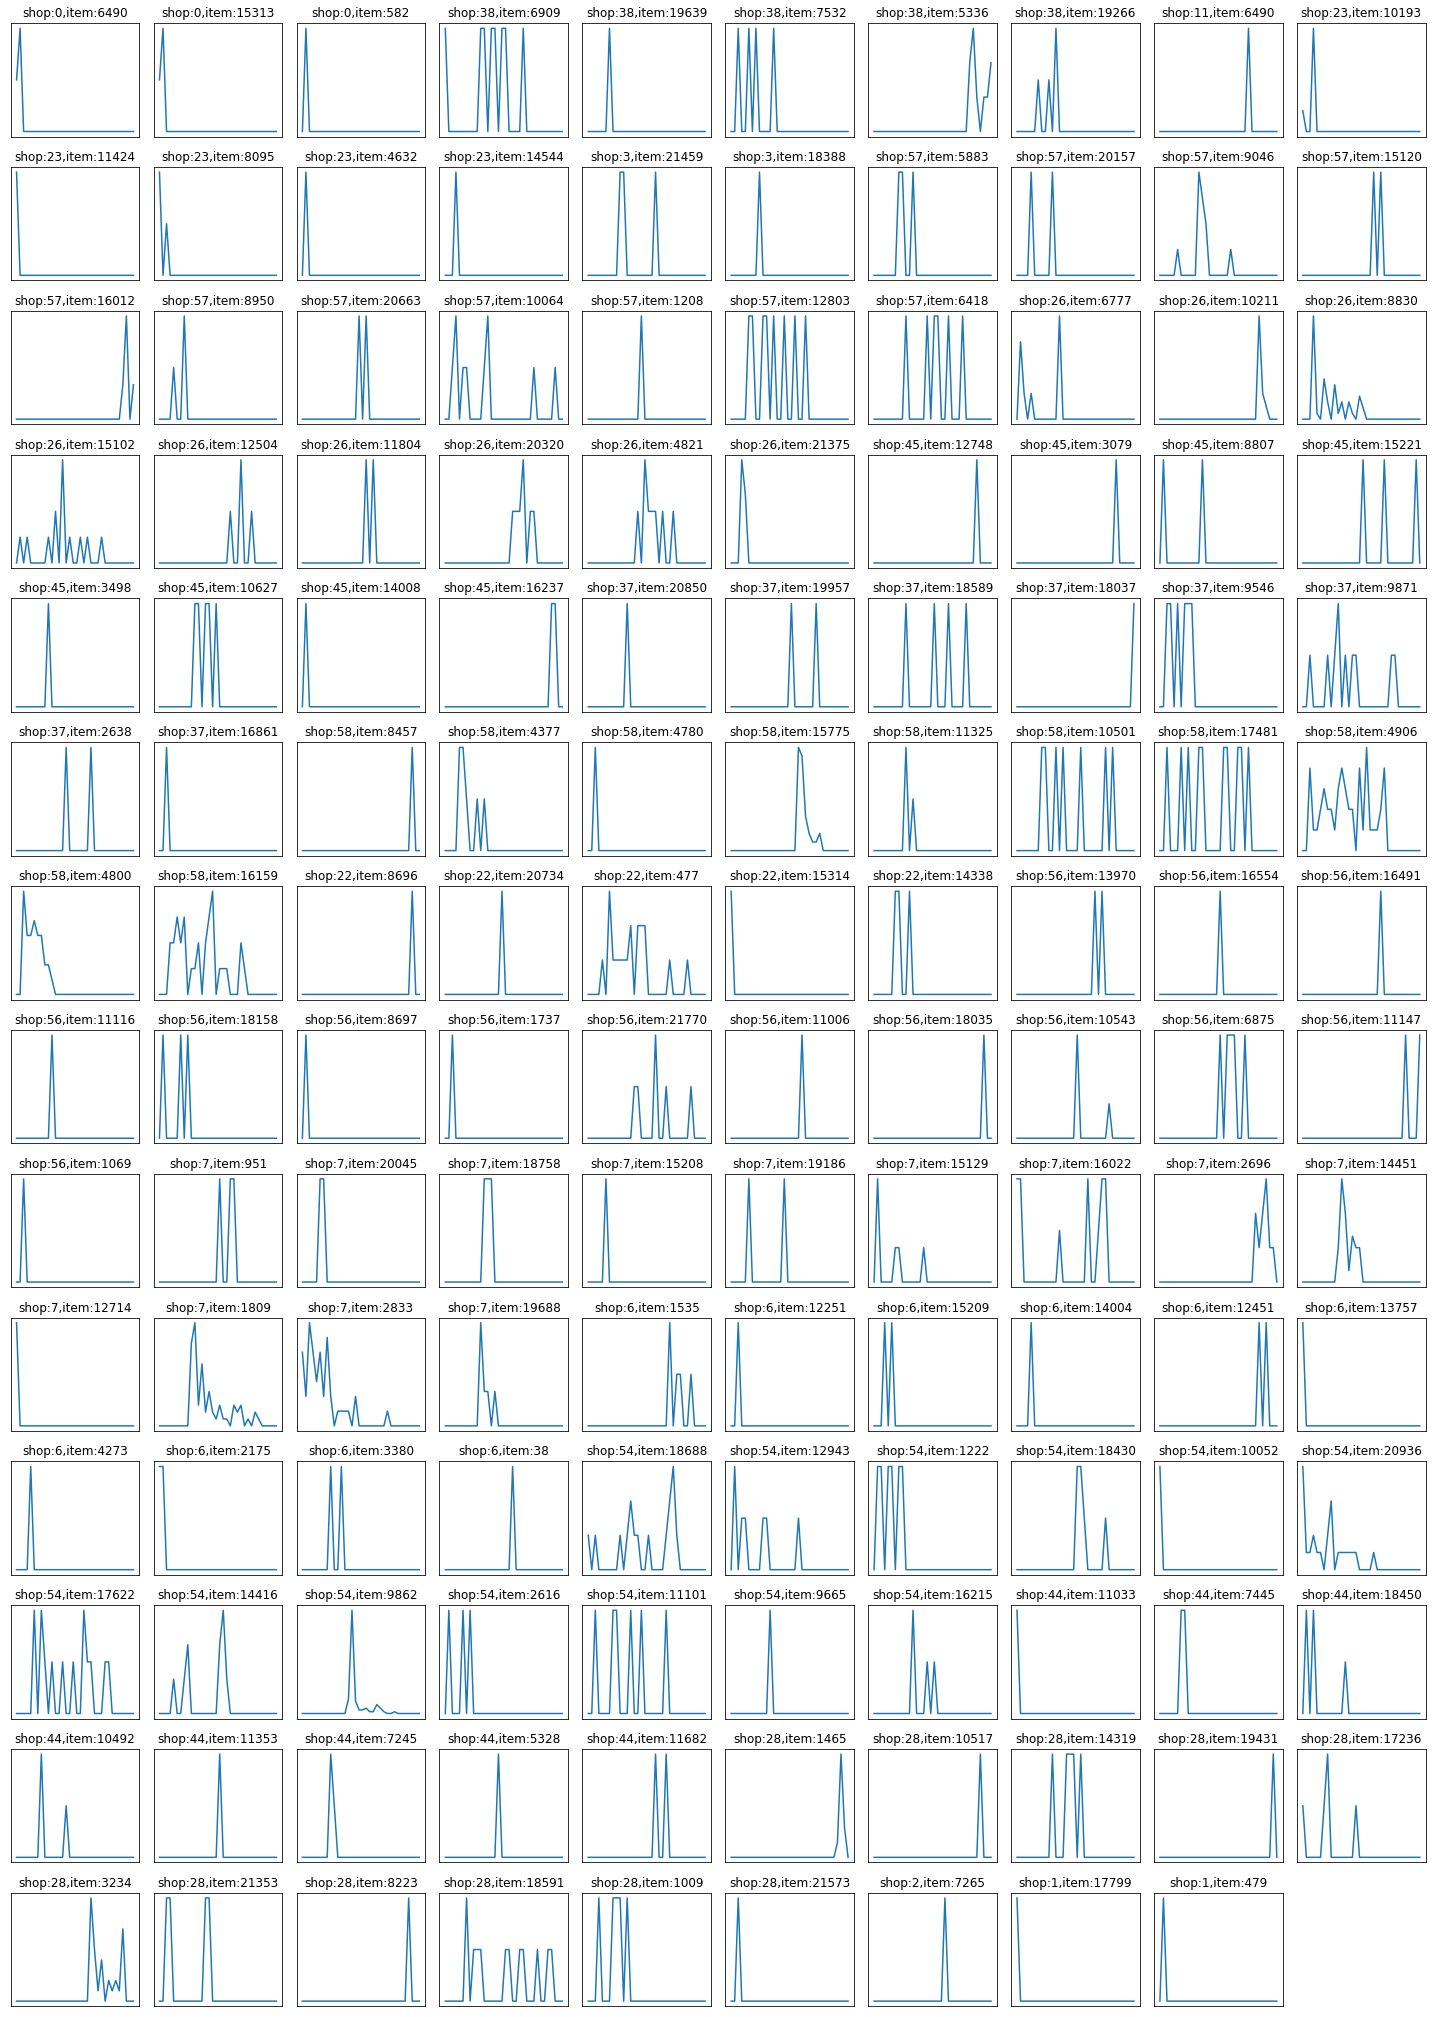

In [4]:
# visualizando as séries por shop e item
unique_shops = list(set([ind[0] for ind in train.index]))
unique_items = list(set([ind[1] for ind in train.index]))

plt.figure(figsize=(20,80))
count = 1
for shop_id in sample(unique_shops, 20):
    for item_id in sample(unique_items, 20):
        try:
            df = train.loc[(shop_id, item_id)].reset_index().drop(["shop_id","item_id"],axis=1)
            df = fill_missed_date_blocks(df)
            plt.subplot(40,10,count)
            count+= 1
            plt.plot(df.date_block_num, df.item_cnt_day)
            plt.xticks([])
            plt.yticks([])
            plt.title(f'shop:{shop_id},item:{item_id}')
        except:
            continue
plt.tight_layout()
plt.show()

**Baseline $X_{t} = mean(X)$**

In [5]:
mean_train = train.reset_index().groupby(['shop_id','item_id']).mean()

In [6]:
def get_mean(shop_id, item_id):
    
    try:
        return mean_train.loc[(shop_id, item_id), "item_cnt_day"]
    except:
        return 0

In [7]:
# lendo o teste
test = pd.read_csv('test.csv')

# aplicando nosso modelo
test["item_cnt_month"] = test.apply(
    lambda x: get_mean(shop_id=x['shop_id'], item_id=x['item_id']), axis=1)

# salvando o resultado em csv para submissão
test[["ID","item_cnt_month"]].to_csv("submission_00.csv", index=None)

### Resultados

- **Posição:** 12686 de 13408 (Top 94,6%)
- **Score:** 2.94933

**Baseline $X_{t} = min(X)$**

In [8]:
min_train = train.reset_index().groupby(['shop_id','item_id']).min()

In [9]:
def get_min(shop_id, item_id):
    
    try:
        return min_train.loc[(shop_id, item_id), "item_cnt_day"]
    except:
        return 0

In [10]:
# lendo o teste
test = pd.read_csv('test.csv')

# aplicando nosso modelo
test["item_cnt_month"] = test.apply(
    lambda x: get_min(shop_id=x['shop_id'], item_id=x['item_id']), axis=1)

# salvando o resultado em csv para submissão
test[["ID","item_cnt_month"]].to_csv("submission_01.csv", index=None)

## Resultados

- **Posição:** 11706 de 13408 (Top 87,3%)
- **Score:** 1.58773

**Baseline $X_{t} = X_{t-1}$**

In [23]:
last_train = train[train['date_block_num'] == 33]

In [24]:
def get_last(shop_id, item_id):
    try:
        return last_train.loc[(shop_id, item_id)]['item_cnt_day']
    except:
        return 0

In [25]:
# lendo o teste
test = pd.read_csv('test.csv')

# aplicando nosso modelo
test["item_cnt_month"] = test.apply(
    lambda x: get_last(shop_id=x['shop_id'], item_id=x['item_id']), axis=1)

# salvando o resultado em csv para submissão
test[["ID","item_cnt_month"]].to_csv("submission_02.csv", index=None)

## Resultados

- **Posição:** 13107 de 13408 (Top 97,755%)
- **Score:** 8.53027

# Conclusões

O melhor baseline é aquele que opta pelo mínimo da série histórica.

# Referências

- https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview